# Dorsal Decoding on Onset Phoneme Monitoring

In [1]:
#Load the required libraries
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Model,load_model
from keras import backend as K
from keras import models, layers
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
import re
import json
import seaborn as sns

from IPython.display import display, HTML
from pdb import set_trace

%matplotlib inline
sns.set()

## Data Preprocessing

In [2]:
#create dicts from csv
##------------------------------ Dataset -------------------------------------##
import csv
import threading


#csv.field_size_limit(10**7)

def read_dict(path):
    'Reads Python dictionary stored in a csv file'
    dictionary = {}
    for key, val in csv.reader(open(path)):
        dictionary[key] = val
    return dictionary

# Load partitions
partition = read_dict('/PATH/dicts/partition.csv')

def read_patterns(csv_file):
    '''
    Reads in target patterns of the form:
        label,v1,v2,...,vN
    '''
    pattern_dict = {}
    with open(csv_file,'r') as f:
        for line in f:
            atoms = line.strip().split(',')
            word = atoms[0]
            pattern = np.array([float(x) for x in atoms[1:]])
            pattern_dict[word] = pattern
    return pattern_dict

# Load dictionary of labels
labels = read_patterns('/PATH/dicts/PhonMo_Final.csv')
#print(labels)


exec("partition['train'] = " + partition['train'])
exec("partition['validation'] = " + partition['validation'])
exec("partition['test'] = " + partition['test'])

# # Final computations
# partition['train'] = partition['train'] 
# partition['validation'] = partition['validation']
# partition['test'] = partition['test']

partition['full'] = partition['train'] + partition['validation'] + partition['test']
partition['train'] = partition['train'] + partition['validation']
partition['validation'] = partition['test']

In [3]:
#Define the Data Generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    my_list = [] #global variable for getting the IDs
    my_labels = [] #global variable for getting the labels
    def __init__(self, list_IDs, labels, batch_size=8800, dim=(226,211), #n_channels=1,
                 n_classes=7, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.my_list = []
        self.my_labels = []
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # FA and NS added this part to get the names of the words
        if index == 0:
            indexes2 = self.indexes[index*8800:(index+1)*8800] #7900 become 800 for the val data
            list_IDs_temp2 = [self.list_IDs[k] for k in indexes2]
            self.my_list = list_IDs_temp2 # This is for getting shuffled list_IDs for get_my_list
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        #check shape
        #print('X : shape = %s, type = %s' % (X.shape, X.dtype) ) # If np.array
        #print('y : shape = %s, type = %s' % (y.shape, y.dtype) )

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))#, self.n_channels))
        #y = np.empty((self.batch_size), dtype=int)
        y = np.empty((self.batch_size, 226)) #226 is the max len here
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('/PATH/Cochs/' + ID + '.npy') #data1 for the toy

            # Store class
            y[i] = self.labels[ID]
        
        self.my_labels = y
       
        return X, y#keras.utils.to_categorical(y, num_classes=self.n_classes)

In [4]:
# Parameters for the Data Generator
params = {'dim': (226,211),
          'batch_size': 8800,
          'n_classes': 7,
          #'n_channels': 1,
          'shuffle': True}

# Datasets
partition = partition
labels = labels

# Generators
full_generator = DataGenerator(partition['full'], labels, **params)
training_generator = DataGenerator(partition['train'], labels, **params) #9 token per word
validation_generator = DataGenerator(partition['validation'], labels, **params) #1 token per word

In [5]:
#Load the model and chose the penultimate layer
import tensorflow as tf

model = tf.keras.models.load_model('/bestdorsalmodel.hd5f')
#model.summary()
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer('lstm').output)
intermediate_layer_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_input (InputLayer)   [(None, 226, 211)]        0         
_________________________________________________________________
masking (Masking)            (None, 226, 211)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 226, 512)          1482752   
Total params: 1,482,752
Trainable params: 1,482,752
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Get the features from the model for the test data
features = intermediate_layer_model.predict(full_generator, verbose=0)
print(features.shape)
features = features[:,0:226,:] #to choose the features from the first 25 time slices
features = features.reshape(8800,226*512) # reshape so that 3D to 2D
print(features.shape)

(8800, 226, 512)
(8800, 115712)


In [8]:
#Get the labels from the Data Generator
y = full_generator.my_labels[:,0]
y = np.array(y, dtype='int64')
print(y.shape)

(8800,)


In [11]:
#put the features to a data frame
data = pd.DataFrame(features) #X_new if you do feature selection
#data.head()

#Get word IDs from the Data Generator
data = pd.DataFrame(data, columns=data.columns, index=data.index)
data['Words'] = np.array(full_generator.my_list)
data = data.set_index('Words')

#Get the labels from the Data Generator
#data['Labels'] = test_generator.my_labels[:,0]

#save the data frame and look at the data
#data.to_csv('/autofs/space/euler_001/users/lstm/data.csv')
data.head

<bound method NDFrame.head of                        0         1         2         3         4       \
Words                                                                   
risky-Kathy         -0.052533 -0.004499 -0.020388 -0.098086  0.037604   
needs-Kathy         -0.037243 -0.004055 -0.021268 -0.127034  0.047631   
success-Agnes       -0.021754  0.034935 -0.041550 -0.133021  0.054326   
conclusion-Victoria -0.007590  0.043796 -0.095404 -0.092505  0.045202   
cared-Bruce         -0.025670 -0.021819 -0.021870 -0.085162  0.045080   
...                       ...       ...       ...       ...       ...   
enlarge-Vicki       -0.036867 -0.001128 -0.030307 -0.059405  0.055148   
needs-Agnes         -0.046005  0.001838 -0.008537 -0.153633  0.030930   
help-Vicki          -0.028343 -0.014860 -0.028989 -0.056262  0.048250   
years-Agnes         -0.035265  0.005513 -0.015513 -0.117969  0.047653   
cooked-Bruce        -0.008455  0.027236 -0.065945 -0.124856  0.047687   

                    

# Steps to Clustering

## PCA for Just Visual

In [13]:
#Scaling and Dimensionality Reduction
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pipeline = Pipeline(steps=[
  ('scaler', StandardScaler(with_mean=False)),
  ('dim_reduction', PCA(n_components=100, random_state=0))
])

pc = pipeline.fit_transform(data)

# plt.figure(figsize=(6, 5))
# sns.scatterplot(x=pc[:,0], y=pc[:,1])
# plt.xlabel("PC1")
# plt.ylabel("PC2");

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8800 samples in 0.002s...
[t-SNE] Computed neighbors for 8800 samples in 1.728s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8800
[t-SNE] Computed conditional probabilities for sample 2000 / 8800
[t-SNE] Computed conditional probabilities for sample 3000 / 8800
[t-SNE] Computed conditional probabilities for sample 4000 / 8800
[t-SNE] Computed conditional probabilities for sample 5000 / 8800
[t-SNE] Computed conditional probabilities for sample 6000 / 8800
[t-SNE] Computed conditional probabilities for sample 7000 / 8800
[t-SNE] Computed conditional probabilities for sample 8000 / 8800
[t-SNE] Computed conditional probabilities for sample 8800 / 8800
[t-SNE] Mean sigma: 19.204169
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.691986
[t-SNE] KL divergence after 1000 iterations: 0.447079


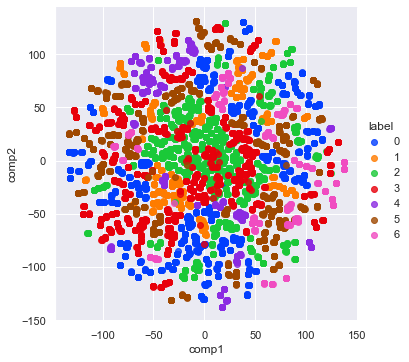

In [20]:
# randomly sample data to run quickly
rows = np.arange(8800)
np.random.shuffle(rows)
n_select = 10000

# reduce dimensionality with t-sne
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(pc[rows[:n_select],:])
# visualize
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]
sns.set_palette("bright")#("rocket", as_cmap=True)
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

In [26]:
sns.color_palette()

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [18]:
#Print out the PCA explained variance
x = StandardScaler(with_mean=False).fit_transform(data)
pca = PCA(n_components=2)
pca.fit(x)
print(pca.explained_variance_ratio_)

[0.04397583 0.04068186]


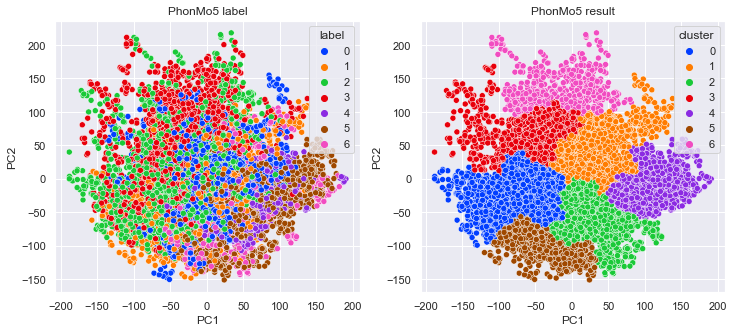

In [21]:
#Just for plotting purposes we use PCA and plot the data on two best features after PCA.
# Create clusters using Agglomerative hierarchical clustering#
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters = 7, affinity='euclidean', linkage='ward', compute_full_tree=True)
y_cluster = agc.fit_predict(pc)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y, palette='bright', ax=ax1);
ax1.set(xlabel="PC1", ylabel="PC2", title="PhonMo5 label")
ax1.legend(title='label')

sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y_cluster, palette='bright', ax=ax2);
ax2.set(xlabel="PC1", ylabel="PC2", title="PhonMo5 result")
ax2.legend(title='cluster');

## Normal Clustering using all the features

In [22]:
#Now we go back to data and use Scaling and do the Clustering on 512 features
scaled_data = StandardScaler(with_mean=False).fit_transform(data)
print(scaled_data.shape)

#Doing the clustering based on 512 features
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters = 7, affinity='euclidean', linkage='ward', compute_full_tree=True)
y_cluster = agc.fit_predict(scaled_data)

(8800, 115712)


In [23]:
#Let's see how the data looks like after clustering
data = pd.DataFrame(scaled_data)
pc_data = pd.DataFrame(data, columns=data.columns, index=data.index)
pc_data['cluster'] = y_cluster
pc_data['Words'] = np.array(full_generator.my_list)
pc_data = pc_data.set_index('Words')

pc_data.head()

,0,1,2,3,4,5,6,7,8,9,...,115703,115704,115705,115706,115707,115708,115709,115710,115711,cluster
Words,,,,,,,,,,,,,,,,,,,,,
murdering-Fred,-2.951280,-1.236229,-1.198213,-2.908801,3.984501,0.043222,-2.767777,-0.579898,1.766165,0.641928,...,-1.061188,-1.747012,0.000225,0.030230,2.131305,0.637360,0.043922,0.015787,-0.011207,4
denial-Princess,-3.305939,0.280942,-0.766714,-4.658293,4.459939,0.221630,-2.990092,0.730651,2.279628,1.095673,...,-1.026553,-1.322784,0.000122,0.043047,-0.079150,0.407481,0.354760,0.010362,-0.107084,0
talk-Victoria,-1.500449,-0.372743,-1.958809,-2.531038,5.354805,-0.896930,-2.826238,-0.609987,1.588956,0.451414,...,1.076159,-1.671808,0.000317,-0.640419,-0.176672,0.168026,1.280490,0.218239,-0.065679,2
emerges-Kathy,-2.874692,-0.130820,-0.984317,-4.161083,4.621248,-0.603146,-2.124673,0.092480,1.991431,1.534377,...,-1.126067,-1.438608,0.000449,0.016839,2.023978,1.743835,1.421152,0.019626,-0.003867,1
odd-Kathy,-3.054368,0.078940,-1.186375,-3.191761,4.033883,1.412158,-3.303478,0.610657,1.962860,1.003332,...,1.228086,-1.887493,0.000079,0.412044,-0.890641,2.298115,1.443925,0.084232,-0.093453,2


In [24]:
#cluster counts
CC = np.bincount(y_cluster)
print ("Cluster Counts:", CC)
#true class counts
TC = np.bincount(y)
print ("True Label Counts:", TC)

Cluster Counts: [1975 1272 2348  764 1420  428  593]
True Label Counts: [1657  865 2073 1763  559 1364  519]


In [25]:
# Find the size of the clusters
pc_data["cluster"].value_counts()

2    2348
0    1975
4    1420
1    1272
3     764
6     593
5     428
Name: cluster, dtype: int64

## Clustering performance evaluation

In [28]:
from sklearn import metrics
# labels_true = [0, 0, 0, 1, 1, 1]
# labels_pred = [0, 0, 1, 1, 2, 2]
labels_true = y
labels_pred = y_cluster

In [29]:
# Mutual Information based scores
print ("Mutual Info:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print ("Normalized Mutual Info:", metrics.normalized_mutual_info_score(labels_true, labels_pred))
print ("Adjusted Mutual Info:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
#Perfect labeling is scored 1.0, bad labeling have non-positive scores.

Mutual Info: 0.4241052898187307
Normalized Mutual Info: 0.42475418914646157
Adjusted Mutual Info: 0.4241052898187307
